In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Read, formate the data, and train using the base model with sigmoid as activation function

In [2]:
df = pd.read_csv('data.csv', usecols=[*range(0,12)], names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
# cols
columns = [*range(0, 12)]
categorical_columns = [1, 3, 5, 6, 7]
# if data is categorical, transform them
df_ohe = df.copy()
for index, i in enumerate(columns):
    if index in categorical_columns:
        ohe = OneHotEncoder()
        feature_arr = ohe.fit_transform(df[[index]]).toarray()
        feature_label = [str(index) + "_" + str(k)
                         for k in range(feature_arr.shape[1])]
        feature = pd.DataFrame(feature_arr, columns=feature_label)
        # drop the last col
        # feature = feature.iloc[:, :-1]
        df_ohe = pd.concat([df_ohe, feature], axis=1)
        df_ohe.drop(index, axis=1, inplace=True)

# set up X, y
X = df_ohe.drop(11, axis=1).values
y = df_ohe[11].values
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

Epoch 00455: early stopping
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[2171   97]
 [ 416  316]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      2268
           1       0.77      0.43      0.55       732

    accuracy                           0.83      3000
   macro avg       0.80      0.69      0.72      3000
weighted avg       0.82      0.83      0.81      3000

accuracy_score 0.829


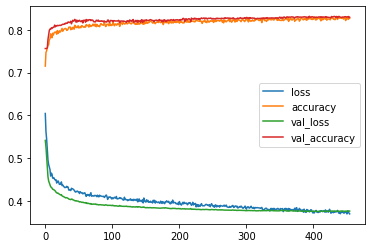

In [3]:
# scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# model set up
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', patience=50, verbose=1)


model = Sequential()
model.add(Dense(units=50, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=25, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
# loss for binary
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'],)

# fit
model.fit(x=X_train, y=y_train, epochs=1000, validation_data=(
    X_test, y_test), verbose=0, callbacks=early_stop)

# plot
model_loss = pd.DataFrame(model.history.history)
model_loss.plot().figure.savefig('base_sigmoid.png')


# metrics
predictions = model.predict_classes(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("accuracy_score", accuracy_score(y_test, predictions))

### Read and format the data from new.csv

In [4]:
df_new = pd.read_csv('new.csv', usecols=[*range(0,11)], names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [5]:
columns = [*range(0, 11)]
df_ohe_new = df_new.copy()
for index, i in enumerate(columns):
    if index in categorical_columns:
        ohe = OneHotEncoder()
        feature_arr = ohe.fit_transform(df_new[[index]]).toarray()
        feature_label = [str(index) + "_" + str(k)
                         for k in range(feature_arr.shape[1])]
        feature = pd.DataFrame(feature_arr, columns=feature_label)
        # drop the last col
        # feature = feature.iloc[:, :-1]
        df_ohe_new = pd.concat([df_ohe_new, feature], axis=1)
        df_ohe_new.drop(index, axis=1, inplace=True)
        
        
# scale the data
X_new = scaler.transform(df_ohe_new.values)

In [6]:
# make predictions
new_predictions = model.predict_classes(X_new)

In [7]:
# check value counts of the new_predictions
pd.Series(new_predictions[:,0]).value_counts()

0    853
1    147
dtype: int64

In [8]:
df_new = pd.concat([df_new, pd.Series(new_predictions[:,0], name=11)], axis=1)

In [9]:
df_new.to_csv('predictions.csv')